# Introduction to Dataset

### Preprocessing

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def round_to_nearest_5_minutes(df):
    # Ensure CompletionDateTime is in datetime format
    df['CompletionDateTime'] = pd.to_datetime(df['CompletionDateTime'], errors='coerce')
    # Drop rows with invalid datetime entries
    df = df.dropna(subset=['CompletionDateTime'])
    # Round CompletionDateTime to the nearest 5 minutes
    df['CompletionDateTime'] = df['CompletionDateTime'].dt.round('5min')
    return df

def remove_cgm_on_time_overlap(df):
    # Identify duplicates based on CompletionDateTime
    duplicate_times = df[df.duplicated('CompletionDateTime', keep=False)]
    # Filter out rows where Type is EVG and CompletionDateTime is duplicated
    df = df[~((df['CompletionDateTime'].isin(duplicate_times['CompletionDateTime'])) & (df['Type'] == 'CGM'))]
    
    return df

def convert_data(df):
    # Example Bolus table columns
    bolus_columns = [
        'Type', 'BolusType', 'BolusDeliveryMethod', 'BG (mg/dL)', 'SerialNumber',
        'CompletionDateTime', 'InsulinDelivered', 'FoodDelivered', 'CorrectionDelivered',
        'CompletionStatusDesc', 'BolexStartDateTime', 'BolexCompletionDateTime', 
        'BolexInsulinDelivered', 'BolexCompletionStatusDesc', 'StandardPercent', 
        'Duration (mins)', 'CarbSize', 'TargetBG (mg/dL)', 'CorrectionFactor', 'CarbRatio'
    ]

    # 1. Create a template DataFrame for Bolus table with default values
    template_bolus = pd.DataFrame(columns=bolus_columns)

    # Default values for missing fields
    default_numeric = 0
    default_categorical = ''

    # 2. Map EVG fields to Bolus fields
    mapped_bolus = evg_df.rename(columns={
        'Readings (mg/dL)': 'BG (mg/dL)',
        'SerialNumber': 'SerialNumber',
        'EventDateTime': 'CompletionDateTime'
    })

    # 3. Add missing columns with default values
    for col in bolus_columns:
        if col not in mapped_bolus.columns:
            if col in ['BG (mg/dL)', 'InsulinDelivered', 'FoodDelivered', 'CorrectionDelivered', 
                    'StandardPercent', 'Duration (mins)', 'CarbSize', 'TargetBG (mg/dL)', 
                    'CorrectionFactor', 'CarbRatio']:  # Numeric fields
                mapped_bolus[col] = default_numeric
            elif col == 'Type':
                mapped_bolus[col] = 'CGM'
            else:  # Categorical fields
                mapped_bolus[col] = default_categorical

    # 4. Reorder columns to match the Bolus table structure
    mapped_bolus = mapped_bolus[bolus_columns]

    # Resulting Bolus DataFrame
    #print(mapped_bolus)
    return mapped_bolus


def min_max_scaling(df, field):
    scaler = MinMaxScaler(feature_range=(0, 1))
    fieldNew = "Scaled" + field
    df[fieldNew] = scaler.fit_transform(df[[field]])
    return df

def map_categories_to_indices(df, columns):
    """
    Map categorical values to numeric indices.
    """
    mappings = {}
    for col in columns:
        df[col] = df[col].astype('category')
        df[f"{col}_idx"] = df[col].cat.codes  # Create numeric indices
        mappings[col] = dict(enumerate(df[col].cat.categories))  # Save mappings
    return df, mappings

def onehot_encoding(df, columns):
    df = pd.get_dummies(df, columns=columns)
    return df

def onehot_encoding_with_all_categories(df, categorical_columns, all_possible_categories):
    """
    One-hot encode specified categorical columns, ensuring all possible categories are included.
    """
    for col in categorical_columns:
        df[col] = pd.Categorical(df[col], categories=all_possible_categories[col])
    df = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns, dummy_na=False)
    return df


# Load the CSV files into pandas DataFrames
#file_path1 = './DataTables/BG.csv'  # Replace with the actual path for Table 1
file_path2 = './DataTables/EVG.csv'  # Replace with the actual path for Table 2
file_path3 = './DataTables/Bolus.csv'  # Replace with the actual path for Table 3

# Load the data
#df1 = pd.read_csv(file_path1)
evg_df = pd.read_csv(file_path2)
bolus_df = pd.read_csv(file_path3)

evg_mapped = convert_data(evg_df)

df = pd.concat([bolus_df, evg_mapped], ignore_index=True)
#print(evg_mapped)

# Round CompletionDateTime to the nearest 5 minutes
df = round_to_nearest_5_minutes(df)

# Sort the DataFrame by CompletionDateTime
df = df.sort_values(by='CompletionDateTime').reset_index(drop=True)

df = remove_cgm_on_time_overlap(df)
columns=['Type', 'BolusType', 'BolusDeliveryMethod', 'CompletionStatusDesc']
# Apply the function
#df = onehot_encoding(df, columns)
columns=['SerialNumber', 'BolexStartDateTime', 'BolexCompletionDateTime', 'BolexInsulinDelivered', 'BolexCompletionStatusDesc', 'Type', 'BolusType', 'BolusDeliveryMethod', 'CompletionStatusDesc']
df = df.drop(columns=columns)
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

df.rename(columns={'CompletionDateTime': 'Date'}, inplace=True)

# Move the 'Date' column to the first position
first_col = df.pop('Date')  # Remove 'Date' column
df.insert(0, 'Date', first_col)  # Reinsert it at position 0

# Write the DataFrame
df.to_csv('merged_data.csv', index=False)

# Organize data, make date into an index
df.set_index("Date", inplace=True)
values = df.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Choosing a Model

### Baseline Example: Random Selection

### Introduction to Time Series
Initially, we considered using linear regression. However, sources online, as well as our professor, informed us that our problem was better framed as a "Time Series" problem and that Neural Networks are excellently suited for tackling these kinds of problems. We will get to Neural Networks and the model we chose in a minute, but first, what is a Time Series?

*GeeksforGeeks* defines a Time Series as, "a sequence of data points collected, recorded, or measured at successive, evenly-spaced time intervals." Most of our data certainly fits this criteria. We have a long record of various biological data collected over the course of eight months at intervals of five minutes. However, some of our data was recorded at irregular time intervals. We address this later in our section on Data Preprocessing, but we ultimately decided to merge the two datasets and the round the irregular time records to the nearest five-minute mark. This way, we have consistent intervals, and by sacrificing some precision in timing, we gain a wealth of information about food consumption times, carbs consumed, insulin delivered, etc.



### Components of a Time Series
Digging a little deeper into Time Series, we see that Time Series have four main components:
* **Trend**: The long-term movement of data over the course of the entire timeframe. An example would be rising air temperatures over the course of decades.
* **Seasonality**: Periodic patterns that occur at regular intervals in the data. An example would be daily changes in temperature or even changes in temperature over the course of the four seasons.
* **Cycles**: Long-term fluctuations which do not have a fixed period. An example would be market boom and bust cycles. These consistently happen, but not at regular intervals.
* **Noise**: Randomness or unpredictable changes in the data

With the exception of cycles, these components are easy to identify in our data. We've visualized Trend and Seasonality in the code cells below. Noise is readily visible in both visualizations as well.

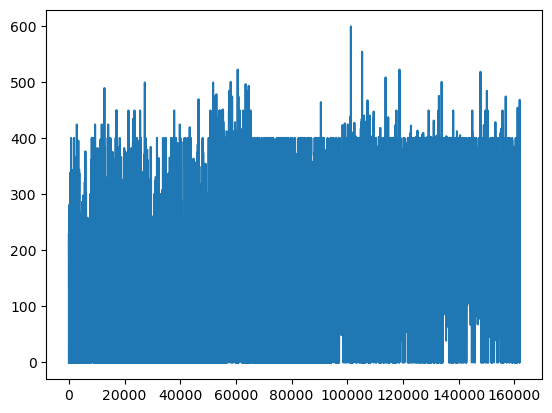

In [ ]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

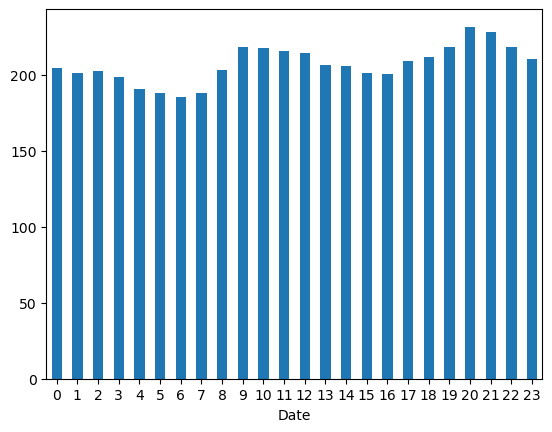

In [4]:
data = pd.read_csv('merged_data.csv')
data.groupby(pd.to_datetime(data['Date']).dt.hour)['BG (mg/dL)'].mean().plot( kind='bar', rot=0 );

### From Neural Networks to Recurrent Neural Networks

### Recurrent Neural Networks Improved: Long-Short Term Memory Model

# Tutorial by Jason Brownlee

Here we simply use the Time Series to Supervised Set formatter written by Jason:

In [191]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Implementation of Tutorial

### Selecting Variables From Our Dataset

### Final Data Preprocessing Step

Loading data from our previously-made Bolus.csv table into a Pandas dataframe:

In [192]:
#import pandas as pd
#from sklearn.preprocessing import MinMaxScaler
#
## Load Bolus Data
#file_path = './DataTables/Bolus.csv'
#df = pd.read_csv(file_path)
#df['CompletionDateTime'] = pd.to_datetime(df['CompletionDateTime'])
#df = df.sort_values(by='CompletionDateTime')

Here we prepare and clean our data:

In [193]:
## Cull Featuers We're Not Using
#df = df[["BG (mg/dL)", "CompletionDateTime", "InsulinDelivered", "FoodDelivered", "CarbSize"]]
#
## Check for NaN values
#print("NaN values:", df.isnull().values.any())
#
## Organize data, make dataframe indexable by date
#df.columns = ["BG", "Date", "InsulinDelivered", "FoodDelivered", "CarbSize"]
#columns_titles = ["Date", "BG", "InsulinDelivered", "FoodDelivered", "CarbSize"]
#df = df.reindex(columns=columns_titles)
#df.set_index("Date", inplace=True)
#print(df.head())
#
## normalize features
#values = df.values
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)

### Multiple Timesteps

The "n_in" parameter in Jason's series_to_supervised() function allows us to transform the data such that each feature's time series is matched by *n* other time series of the feature which are offset by (t-1, t-2, ..., t-n) timesteps. If we leave it at default, we can then see, once we print the head of the dataframe, that it has output two timesteps for each variable. For variable 1, our blood glucose level as shown in the code cell above, there is var1(t-1) and var1(t). If you run the code cell below, you will notice that the time series var1(t-1) is the same series as var1(t) except that the entire series is offset one step into the past. This is the same for every one of the variables / features.

It will be more convenient for us to do this later, but if we culled the last three timesteps, we would be left with a dataframe containing four of previous timestep series for all of our features (var1(t-1), var2(t-2), var3(t-3), var4(t-4)) — our input variables — and one timestep series for the current blood glucose level (var1(t)) — our output variable.

In [194]:
# Transform to supervised set with one timestep
df_reframed = series_to_supervised(scaled, n_in=1, n_out=1)
print(df_reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.00   0.267380   0.267380   0.000000        1.0        0.0   
2       0.22   0.104813   0.089305   0.033333        1.0        0.0   
3       0.00   0.057219   0.057219   0.000000        1.0        0.0   
4       0.00   0.267380   0.267380   0.000000        1.0        0.0   
5       0.00   0.057219   0.057219   0.000000        1.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var1(t)   var2(t)   var3(t)  \
1   0.166667   0.733333        1.0         1.0     0.22  0.104813  0.089305   
2   0.055556   0.733333        1.0         1.0     0.00  0.057219  0.057219   
3   0.035556   0.733333        1.0         1.0     0.00  0.267380  0.267380   
4   0.166667   0.733333        1.0         1.0     0.00  0.057219  0.057219   
5   0.035556   0.733333        1.0         1.0     0.00  0.142781  0.142781   

    var4(t)  var5(t)  var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  
1  0.033333      1.0      0

If we set "n_in" parameter for more timesteps, the result is the same as above but with more timesteps. For our initial attempt, we will use 10 timesteps because we would later like to be able to use data from the last several hours as input into the LSTM to get our predicted blood-glucose level. "n_out" is set to 1 because we want to predict our current blood glucose level.

We *would* like to be able to predict future blood glucose levels (which would be n_out >= 2), but because our data was not recorded at regular intervals, timestep predictions into the future would tell us "how much?" but not exactly "when?". If our data were recorded in regular one hour intervals, we could then rest assured that future timestep predictions would be *n* number of hours into the future precisely. This is a limitation in our dataset or, at least, in the tutorial we have followed to implement our LSTM. The tutorial was working with data on regular intervals. We are not.

In [195]:
# Transform to supervised set with multiple timesteps
n_timesteps = 10
df_reframed = series_to_supervised(scaled, n_in=n_timesteps, n_out=7)
print(df_reframed.head())

    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
10        0.00    0.267380    0.267380    0.000000         1.0         0.0   
11        0.22    0.104813    0.089305    0.033333         1.0         0.0   
12        0.00    0.057219    0.057219    0.000000         1.0         0.0   
13        0.00    0.267380    0.267380    0.000000         1.0         0.0   
14        0.00    0.057219    0.057219    0.000000         1.0         0.0   

    var7(t-10)  var8(t-10)  var9(t-10)  var10(t-10)  ...  var1(t+6)  \
10    0.166667    0.733333         1.0          1.0  ...   0.318333   
11    0.055556    0.733333         1.0          1.0  ...   0.313333   
12    0.035556    0.733333         1.0          1.0  ...   0.296667   
13    0.166667    0.733333         1.0          1.0  ...   0.296667   
14    0.035556    0.733333         1.0          1.0  ...   0.273333   

    var2(t+6)  var3(t+6)  var4(t+6)  var5(t+6)  var6(t+6)  var7(t+6)  \
10        0.0        0.0        

### Split Test and Train Sets

Here we split our data into a training set, comprised of the first half of our time range, and a testing set, comprised of the second half of our time range. We choose to split it this way rather than use standard shuffling methods of generating the sets because our data is only useful insofar as it records a time series. That is, if we scrambled the time series, the data would be relatively meaningless, possessing no information about the relative order nor trends in the data over time.

In [196]:
# Split into train and test sets
values = df_reframed.values
index_midpoint = len(values) // 2
train = values[:index_midpoint,:]
test = values[index_midpoint:,:]

Here we cull all the current timestep features except variable 1, which is the blood glucose level variable we are trying to predict.

In [197]:
# Split into input and outputs
n_features = len(df.columns)
n_obs = n_timesteps * n_features
train_X, train_y = train[:, 0:n_obs], train[:, -n_features]
test_X, test_y = test[:, 0:n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))

### Create and Fit Model

(80960, 10, 10)
Epoch 1/50
1125/1125 - 4s - 4ms/step - loss: 0.0756 - val_loss: 0.0689
Epoch 2/50
1125/1125 - 3s - 3ms/step - loss: 0.0682 - val_loss: 0.0667
Epoch 3/50
1125/1125 - 3s - 3ms/step - loss: 0.0662 - val_loss: 0.0645
Epoch 4/50
1125/1125 - 3s - 3ms/step - loss: 0.0648 - val_loss: 0.0620
Epoch 5/50
1125/1125 - 3s - 3ms/step - loss: 0.0640 - val_loss: 0.0607
Epoch 6/50
1125/1125 - 3s - 3ms/step - loss: 0.0634 - val_loss: 0.0599
Epoch 7/50
1125/1125 - 3s - 3ms/step - loss: 0.0630 - val_loss: 0.0593
Epoch 8/50
1125/1125 - 3s - 3ms/step - loss: 0.0627 - val_loss: 0.0592
Epoch 9/50
1125/1125 - 3s - 3ms/step - loss: 0.0625 - val_loss: 0.0589
Epoch 10/50
1125/1125 - 3s - 3ms/step - loss: 0.0624 - val_loss: 0.0583
Epoch 11/50
1125/1125 - 3s - 3ms/step - loss: 0.0623 - val_loss: 0.0581
Epoch 12/50
1125/1125 - 3s - 3ms/step - loss: 0.0622 - val_loss: 0.0578
Epoch 13/50
1125/1125 - 3s - 3ms/step - loss: 0.0621 - val_loss: 0.0575
Epoch 14/50
1125/1125 - 3s - 3ms/step - loss: 0.0620 - va

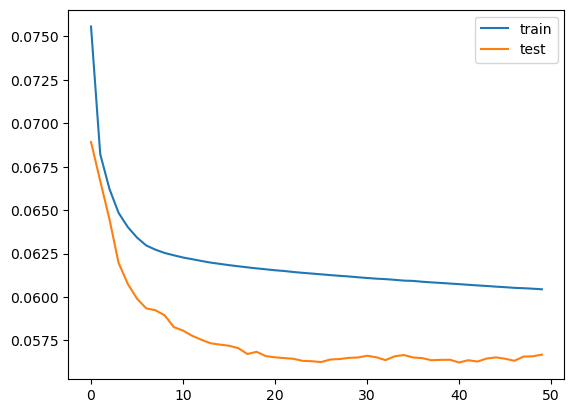

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import LSTM

# design LSTM
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot loss curves
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [207]:
print(history.history['val_loss'])

[0.06891997903585434, 0.06668123602867126, 0.06448561698198318, 0.06195392087101936, 0.060749828815460205, 0.05990162864327431, 0.0593453086912632, 0.05923716351389885, 0.058947257697582245, 0.05826596915721893, 0.05806441977620125, 0.05776430666446686, 0.05753668397665024, 0.057335589081048965, 0.05725826323032379, 0.05719270929694176, 0.05705595389008522, 0.05671481415629387, 0.056844621896743774, 0.05659503489732742, 0.05652610585093498, 0.05648117512464523, 0.056442368775606155, 0.056321777403354645, 0.056301891803741455, 0.056251730769872665, 0.05639934912323952, 0.05642550438642502, 0.056492820382118225, 0.056515712291002274, 0.056617364287376404, 0.05652877688407898, 0.05636526271700859, 0.05658430606126785, 0.056657254695892334, 0.056518469005823135, 0.056477904319763184, 0.05635812506079674, 0.0563797727227211, 0.056385744363069534, 0.05622900649905205, 0.05635903775691986, 0.05628335848450661, 0.05645822361111641, 0.056521303951740265, 0.05644556134939194, 0.05632581189274788

### Evaluate Model

In his original tutorial, Jason used RMSE as his measurement of the performance of the dataset. MAE is, however, significantly easier to understand intuitively. So, we wanted to use MAE, but RMSE is better at finding significant errors, which is especially important since we are trying to predict human blood glucose levels. Luckily, we can use both to gain a better understanding of our dataset.

According to EUMeTrain.org, an international training project for the development of training material and training support in the field of satellite meteorology:

"The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude. Both the MAE and RMSE can range from 0 to ∞. They are negatively-oriented scores: Lower values are better."

So in the code cell below, we calculated MAE, RMSE, and the resulting Variance score.

In [181]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
import numpy as np

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_timesteps*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MAE
mae = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)
rmse = np.sqrt(root_mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
variance = rmse - mae
print('Test Variance: %.3f' % variance)

   1/2531 ━━━━━━━━━━━━━━━━━━━━ 3:22 80ms/step

2531/2531 ━━━━━━━━━━━━━━━━━━━━ 2s 851us/step
Test MAE: 3.472
Test RMSE: 6.215
Test Variance: 2.743


Running the code cell above results in an MAE of 8.372, an RMSE of 10.045, and a variance of 1.673. This variance is very low, and so it is unlikely that very large errors have occured. MAE tells us that the average difference between the forecasted blood glucose level and the observed was 8.3 mg/dL. The monitor our data came from records BG in a range from 0 to 400 mg/dL. 8.372 is only about 2.1% ((8.372 / 400) * 100 = 2.093). So, on average, our model's predicted BG level is only about 2.1% off of the actual level.

# Tuning

### Are we overfitting? Underfitting? How do we tell?

### Which input variables from out dataset are the best predictors?

### What is the optimal number of timestamps?

### What are the best LSTM hyperparameters?

In [182]:
# From tutorial: "Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this)"

# Gird Search implementation like the one explained in Lecture (takes 15 mins to run currently)
def GridSearchHyperparameters(num_neurons, num_epochs, batch_size, validation_data):
    neurons_best = None
    epochs_best = None
    batch_size_best = None
    mae_best = 1000000000000
    for neurons in num_neurons:
        for epochs in num_epochs:
            for batches in batch_size:
                print('------------------------------------')
                print("neurons: " + str(neurons), "epochs: " + str(epochs), "batches: " + str(batches))
                # reset data
                test_X = validation_data[0]
                test_y = validation_data[1]
                # design LSTM
                model = Sequential()
                model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
                model.add(LSTM(neurons))
                model.add(Dense(1))
                model.compile(loss='mae', optimizer='adam')
                # fit LSTM
                model.fit(train_X, train_y, epochs=epochs, batch_size=batches, validation_data=validation_data, verbose=0, shuffle=False)
                # make a prediction
                yhat = model.predict(test_X)
                test_X = test_X.reshape((test_X.shape[0], n_timesteps*n_features))
                # invert scaling for forecast
                inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:,0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:,0]
                # calculate MAE
                mae = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
                # best MAE decision
                if mae < mae_best:
                    neurons_best = neurons
                    epochs_best = epochs
                    batch_size_best = batches
                    mae_best = mae
    return mae_best, neurons_best, epochs_best, batch_size_best

# Split into input and outputs
n_features = 4
n_obs = n_timesteps * n_features
train_X, train_y = train[:, 0:n_obs], train[:, -n_features]
test_X, test_y = test[:, 0:n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))
print(GridSearchHyperparameters(num_neurons=[5,10,25,50],
                                num_epochs=[10, 20, 40, 80],
                                batch_size=[10, 20, 40, 80],
                                validation_data=(test_X, test_y))
      )

------------------------------------
neurons: 5 epochs: 10 batches: 10
2531/2531 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step


ValueError: operands could not be broadcast together with shapes (80963,4) (10,) (80963,4) 

# Results

### Summary

### Limitations

### Credits
* Jason Brownlee's tutorial on how to create a multivariate LSTM in Python @ https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* "The AI Hacker" on YouTube for his informative guide to RNNs @ https://youtu.be/LHXXI4-IEns?si=C4FoMP-Bv4xywsHZ
* EUMeTrain.org for their explanation of MAE, RMSE, and how to assess variance between them @ https://resources.eumetrain.org/data/4/451/english/msg/ver_cont_var/uos3/uos3_ko1.htm


### Use of AI